<a href="https://colab.research.google.com/github/linyunhe/apple_case_study/blob/main/apple_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

# Unzip to /content/apple_case_study
zip_path = "/content/drive/MyDrive/squares.zip"
extract_path = "/content/apple_case_study"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Done：", extract_path)


Done： /content/apple_case_study


In [3]:
import tensorflow as tf

print("Device：")
print(tf.config.list_physical_devices())


Device：
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Check how many categories and how many samples each category contains

In [4]:
import os
for root, dirs, files in os.walk("/content/apple_case_study"):
    print(root, "files:", dirs, "count:", len(files))

/content/apple_case_study files: ['__MACOSX', 'squares'] count: 0
/content/apple_case_study/__MACOSX files: ['squares'] count: 0
/content/apple_case_study/__MACOSX/squares files: ['train', 'val'] count: 3
/content/apple_case_study/__MACOSX/squares/train files: ['a', 'c', 'b'] count: 4
/content/apple_case_study/__MACOSX/squares/train/a files: [] count: 501
/content/apple_case_study/__MACOSX/squares/train/c files: [] count: 500
/content/apple_case_study/__MACOSX/squares/train/b files: [] count: 501
/content/apple_case_study/__MACOSX/squares/val files: ['a', 'c', 'b'] count: 4
/content/apple_case_study/__MACOSX/squares/val/a files: [] count: 500
/content/apple_case_study/__MACOSX/squares/val/c files: [] count: 500
/content/apple_case_study/__MACOSX/squares/val/b files: [] count: 500
/content/apple_case_study/squares files: ['train', 'val'] count: 1
/content/apple_case_study/squares/train files: ['a', 'c', 'b'] count: 1
/content/apple_case_study/squares/train/a files: [] count: 501
/conten

### Findings: we have three categories: a,b,c and each of them have 500 images for both train and val.

Key points: Balance categories data and small training samples

# Image Preprocessing

### Preprocessing include: fix size, set up RGB, normalization and data augmentation

In [5]:
import tensorflow as tf

# Fix image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/apple_case_study/squares/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/apple_case_study/squares/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [6]:
class_names = test_ds.class_names

In [7]:
for images, labels in train_ds.take(1):
    print("image size:", images.shape)
    print("image type:", images.dtype)


image size: (32, 224, 224, 3)
image type: <dtype: 'float32'>


In [8]:
for images, labels in test_ds.take(1):
    print("image size:", images.shape)  # (batch_size, height, width, channels)
    print("image type:", images.dtype)


image size: (32, 224, 224, 3)
image type: <dtype: 'float32'>


Key points: No weird image dtypes

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


# Model sequence (convNet)

In [20]:
from tensorflow.keras import layers, models

model = models.Sequential([
    normalization_layer,  # normalization

    data_augmentation,  # data augmentation

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    # layers.Flatten(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # three class categories
])


Start with a simple convNet (x32x64) and then one layer head (x64) for three categories

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [17]:
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.3351 - loss: 1.1055 - val_accuracy: 0.3333 - val_loss: 1.0995
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3268 - loss: 1.1009 - val_accuracy: 0.3353 - val_loss: 1.0964
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3568 - loss: 1.0971 - val_accuracy: 0.3333 - val_loss: 1.1005
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3535 - loss: 1.0907 - val_accuracy: 0.4533 - val_loss: 1.0696
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5040 - loss: 1.0548 - val_accuracy: 0.5620 - val_loss: 0.9451
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5440 - loss: 0.9104 - val_accuracy: 0.6427 - val_loss: 0.7889
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6707 - loss: 0.7810 - val_accuracy: 0.5127 - val_loss: 0.7545
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6907 - loss: 0.6964 - val_accuracy: 0.7420 - v

### Plot the curve to see whether it is converged

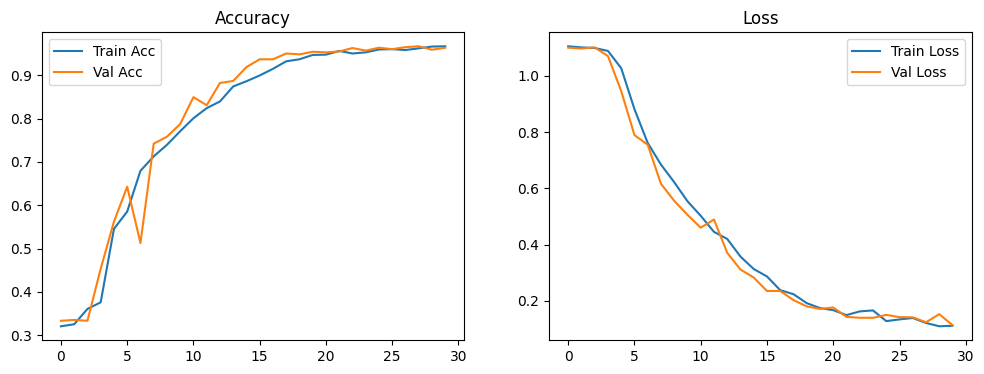

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


It seems like it converges and no overfitting thus save the current model.

In [23]:
model.save('conv_v2_GlobalAveragePooling2D.h5')  # save model


Currenty we know the previous model accuracy is 95% which is good but we can take a deeper look to see whether our model learns each class equivalently good.

In [25]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# class_names = test_ds.class_names

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

Model achieved 97.1% overall accuracy. All three classes had precision and recall in the 96–99% range, with class b being slightly more challenging, likely due to subtle visual overlaps with class a.

Interestingly, I didn’t change the model architecture—just re-trained it with GPU acceleration, better data pipeline (cache + prefetch), and cleaner Colab session. The accuracy jumped from ~92.8% to over 97%. This shows that:

The model was already well-designed

Prior slowness and instability (e.g. CPU + no pipeline optimization) might have caused suboptimal convergence

Training reproducibility and environment tuning can have a major impact even when architecture stays the same”

### After using globalaverage to reduce parameters
Model became much lighter — parameter count dropped from ~12M to under 100K — but performance remained very strong: overall accuracy at 96.7%, with especially robust precision and recall for all classes.”

“This confirms that the model wasn’t undertrained — it had likely learned what it could — and the simplification helped reduce overfitting risk without hurting performance.”



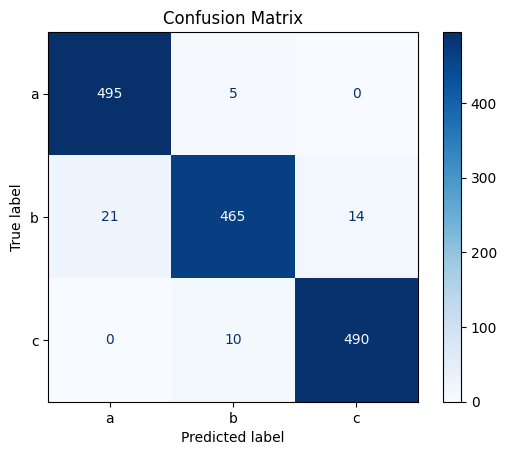

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


So it seems like for for a and c, we have pretty good precision and recall. If we break down b we can found:
almost all a and c are succeeded to clarify and low precision is from b misclaried as a or c.

Thus we can plot some misclarified b and compared it with a to see why they are misclarified

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


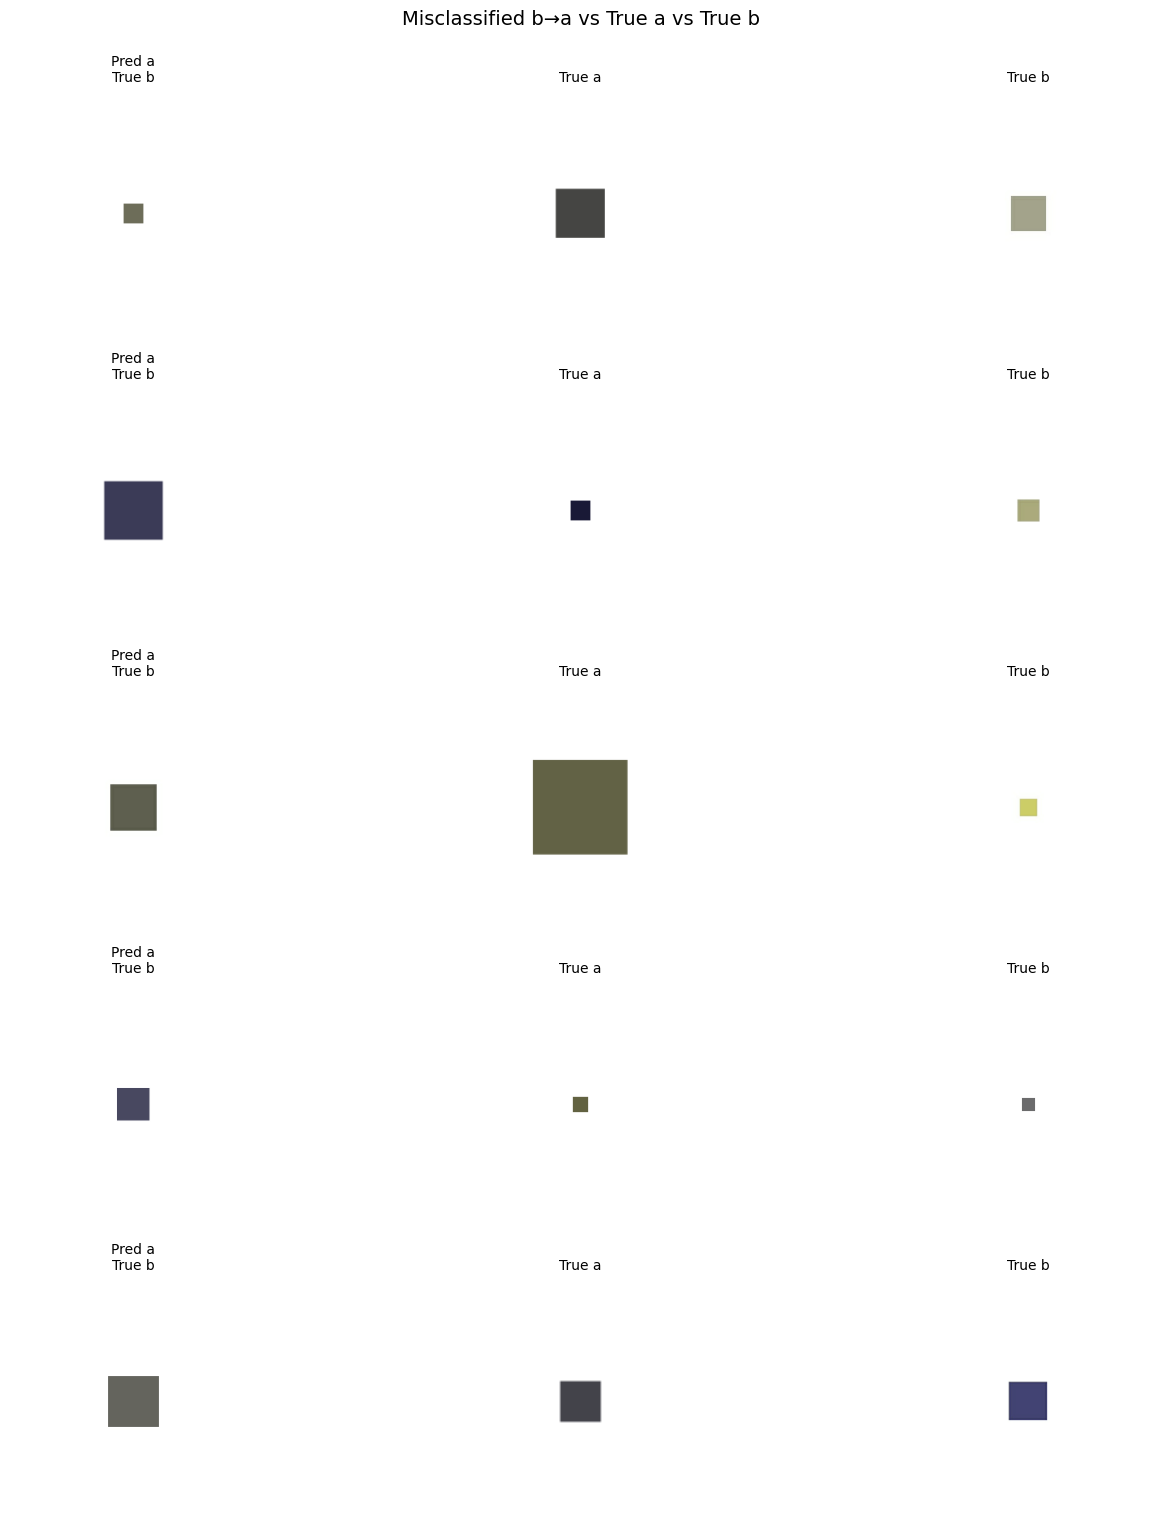

In [27]:
import matplotlib.pyplot as plt
import numpy as np

test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.extend(images)
    test_labels.extend(labels.numpy())

# predict
preds = model.predict(tf.stack(test_images))
pred_labels = tf.argmax(preds, axis=1).numpy()
true_labels = tf.argmax(test_labels, axis=1).numpy()

# focus on a and b
class_index_a = 0
class_index_b = 1

# b misclarify as a
wrong_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == class_index_b and p == class_index_a]

# true a
true_a_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == class_index_a and p == class_index_a]

# true b
true_b_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == class_index_b and p == class_index_b]

# pick top 5 to compare
num_samples = min(5, len(wrong_idx), len(true_a_idx), len(true_b_idx))

plt.figure(figsize=(15, 3 * num_samples))

for i in range(num_samples):
    #（Pred a, True b）
    idx_wrong = wrong_idx[i]
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(test_images[idx_wrong].numpy().astype("uint8"))
    plt.axis('off')
    plt.title("Pred a\nTrue b", fontsize=10)

    # true a
    idx_a = true_a_idx[i]
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(test_images[idx_a].numpy().astype("uint8"))
    plt.axis('off')
    plt.title("True a", fontsize=10)

    # true b
    idx_b = true_b_idx[i]
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(test_images[idx_b].numpy().astype("uint8"))
    plt.axis('off')
    plt.title("True b", fontsize=10)

plt.tight_layout()
plt.suptitle("Misclassified b→a vs True a vs True b", fontsize=14, y=1.02)
plt.show()


In this example, the misclassified b samples are visually indistinguishable from class a — both in terms of color and shape. These errors are not due to model flaws, but rather due to semantic overlap in the input space. Even a human would likely confuse them without additional context.”

“This highlights the limits of purely image-based classification — some ambiguity is inherent, and additional modalities or metadata may be required to push performance further.”

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


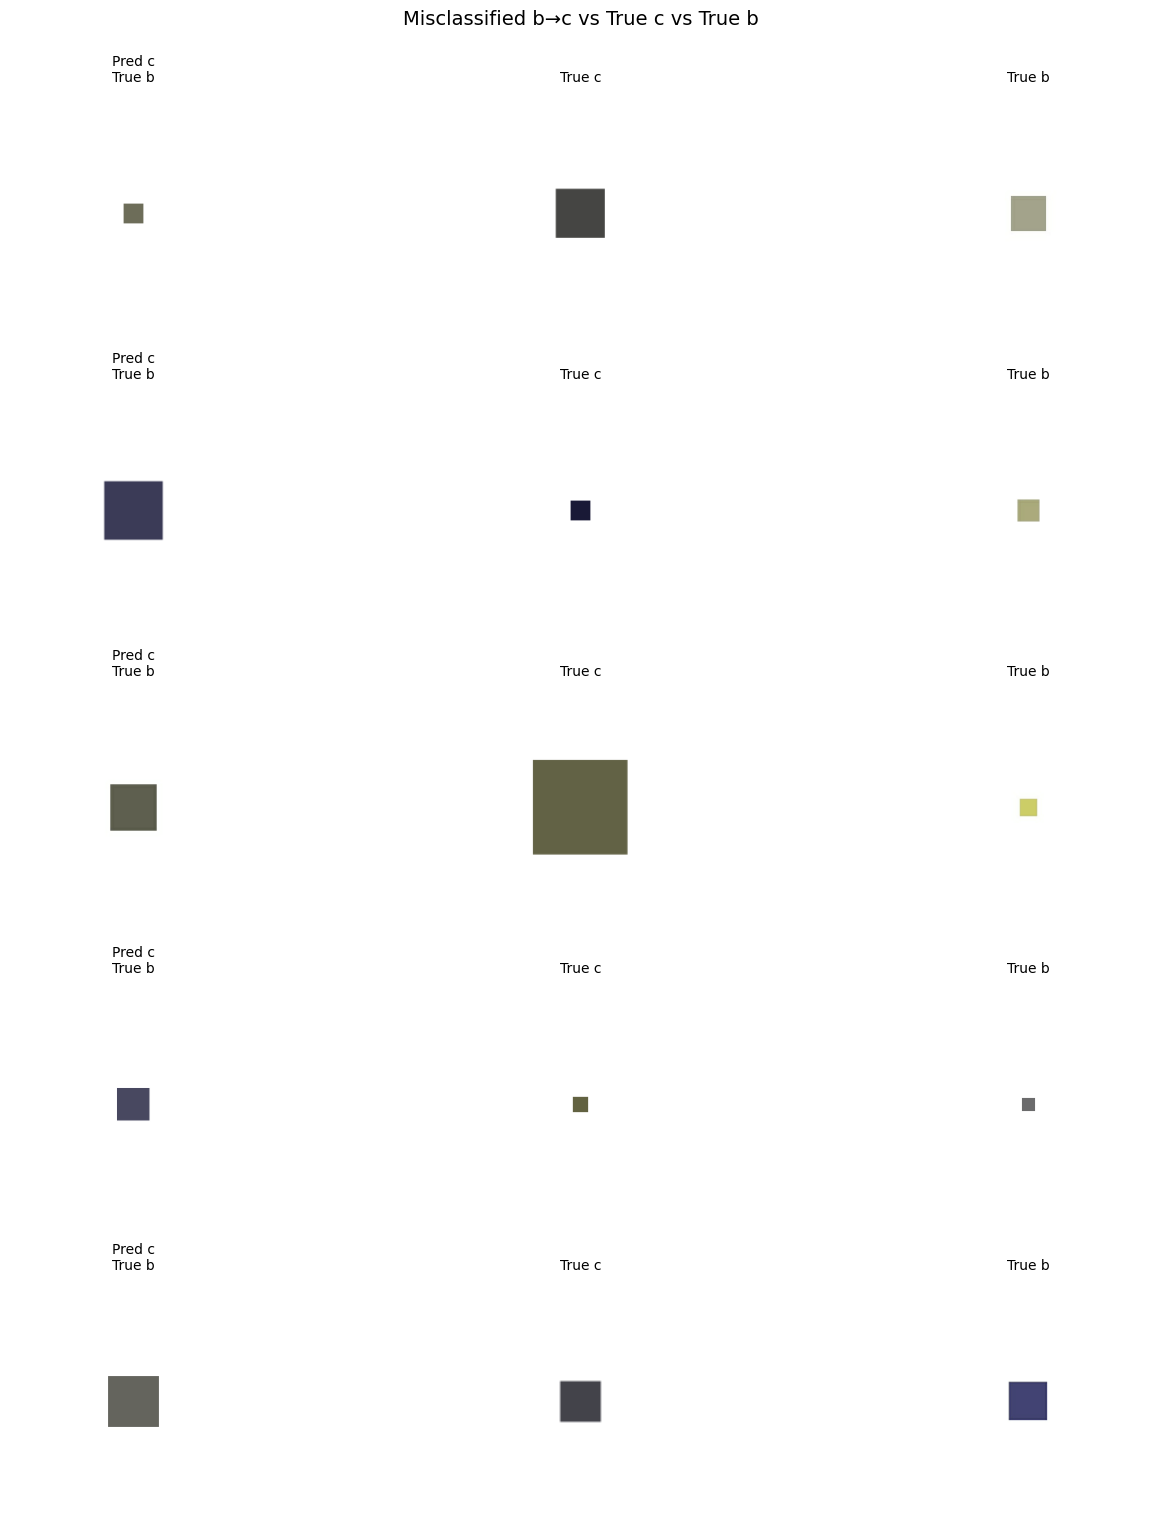

In [28]:
import matplotlib.pyplot as plt
import numpy as np

test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.extend(images)
    test_labels.extend(labels.numpy())

# predict
preds = model.predict(tf.stack(test_images))
pred_labels = tf.argmax(preds, axis=1).numpy()
true_labels = tf.argmax(test_labels, axis=1).numpy()

# focus on a and b
class_index_c = 0
class_index_b = 1

# b misclarify as c
wrong_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == class_index_b and p == class_index_c]

# true c
true_a_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == class_index_c and p == class_index_c]

# true b
true_b_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == class_index_b and p == class_index_b]

# pick top 5 to compare
num_samples = min(5, len(wrong_idx), len(true_a_idx), len(true_b_idx))

plt.figure(figsize=(15, 3 * num_samples))

for i in range(num_samples):
    #（Pred a, True b）
    idx_wrong = wrong_idx[i]
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(test_images[idx_wrong].numpy().astype("uint8"))
    plt.axis('off')
    plt.title("Pred c\nTrue b", fontsize=10)

    # true c
    idx_a = true_a_idx[i]
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(test_images[idx_a].numpy().astype("uint8"))
    plt.axis('off')
    plt.title("True c", fontsize=10)

    # true b
    idx_b = true_b_idx[i]
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(test_images[idx_b].numpy().astype("uint8"))
    plt.axis('off')
    plt.title("True b", fontsize=10)

plt.tight_layout()
plt.suptitle("Misclassified b→c vs True c vs True b", fontsize=14, y=1.02)
plt.show()


## Summary

This model has achieved high accuracy, with both recall and precision in the 92–98% range — particularly strong for class c. Most misclassifications (e.g., class b misclassified as class a) occur on visually ambiguous samples with low information content. In real-world settings, these examples often fall into the category of “even humans would struggle to distinguish them”, indicating that further aggressive optimization is not only unnecessary but potentially misleading.

## Key Insight:

The model has already learned what it should learn — this is not undertraining, but a reflection of the natural ambiguity in the data itself.

## Potential Next Steps:

If class b contains heterogeneous visual patterns, consider splitting it into finer-grained subtypes or re-annotating ambiguous samples for better label clarity.

Optionally explore multi-modal input or contextual metadata, if available, to disambiguate visually similar classes.

